In [2]:
%cd /content

!git clone https://04edf789c52e5b4930be3bbccb51899d47c5a40a@github.com/shonenkov/StackMix-OCR.git
%cd /content/StackMix-OCR

/content
Cloning into 'StackMix-OCR'...
remote: Enumerating objects: 479, done.
remote: Counting objects: 100% (479/479), done.
remote: Compressing objects: 100% (309/309), done.
remote: Total 479 (delta 307), reused 308 (delta 166), pack-reused 0
Receiving objects: 100% (479/479), 3.49 MiB | 10.80 MiB/s, done.
Resolving deltas: 100% (307/307), done.
/content/StackMix-OCR


In [3]:
DATA_DIR = '../StackMix-OCR-DATA'
MWE_TOKENS_DIR = '../StackMix-OCR-MWE_TOKENS'

DATASET_NAME = 'hkr'  # iam|peter|saintgall|iam_tbluche|hkr|bentham
IMAGE_H = 128
IMAGE_W = {'peter': 384}.get(DATASET_NAME, 384)

In [4]:
!python3 scripts/download_dataset.py --dataset_name '{DATASET_NAME}'

Downloading...
From: https://drive.google.com/uc?id=18bS3xJinoKzVJc_p9bEWEXAwavy8WnEz
To: /content/StackMix-OCR-DATA/hkr.tar.gz
100% 690M/690M [00:06<00:00, 100MB/s]


In [5]:
!python scripts/download_dataset.py --dataset_name corpora

Downloading...
From: https://drive.google.com/uc?id=1C9hSJ2R72dgZIdrwIRW0GGjVxiAlWo3G
To: /content/StackMix-OCR-DATA/corpora.tar.gz
100% 159M/159M [00:01<00:00, 131MB/s]


In [6]:
!python scripts/prepare_stackmix.py \
  --dataset_name "{DATASET_NAME}" \
  --data_dir "../StackMix-OCR-DATA" \
  --mwe_tokens_dir "../StackMix-OCR-MWE_TOKENS" \
  --image_w "{IMAGE_W}" \
  --image_h "{IMAGE_H}"

100% 45551/45551 [00:00<00:00, 2694935.28it/s]
100% 45551/45551 [40:40<00:00, 18.66it/s]


In [7]:
import os
print(len(os.listdir("/content/StackMix-OCR-DATA/hkr/images/")))

64943


In [8]:
import sys
import matplotlib.pyplot as plt
import pandas as pd
from src.stackmix import StackMix
from configs import CONFIGS
from src.ctc_labeling import CTCLabeling
import json
import random
import math
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [9]:
stackmix = StackMix(
    mwe_tokens_dir=MWE_TOKENS_DIR,
    data_dir=DATA_DIR,
    dataset_name=DATASET_NAME,
    image_h=IMAGE_H,
    p_background_smoothing=1.0
)
stackmix.load()

In [10]:
config = CONFIGS[DATASET_NAME](DATA_DIR, '', '')
ctc_labeling = CTCLabeling(config)
stackmix.load_corpus(ctc_labeling, f'{DATA_DIR}/corpora/{config.corpus_name}')

100%|██████████| 2227621/2227621 [00:52<00:00, 42071.02it/s]


153 149 183


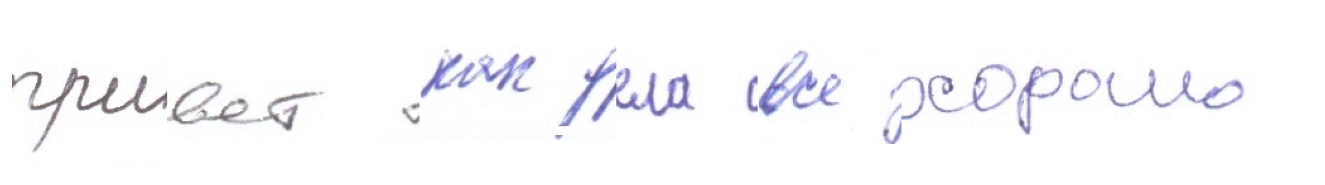

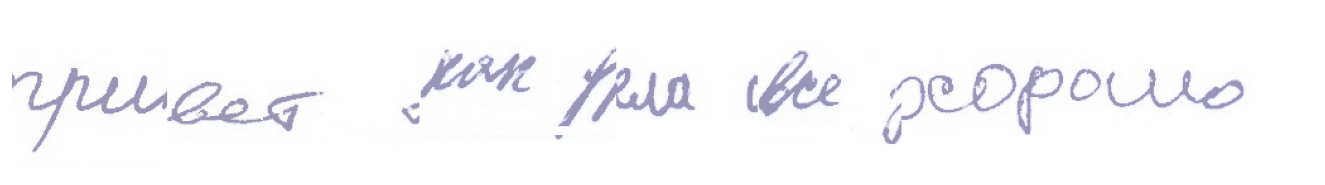

In [11]:
# self.tokenizers[3],
# self.tokenizers[4],
# self.tokenizers[5],
# self.tokenizers[6],
# self.tokenizers[7],
# self.tokenizers[8],
# 200k
# 80/20 -1,2
#img label mean 
t = 'привет как дела все хорошо'
img = stackmix.run_stackmix(t)
R = 0
G = 0
B = 0
count = 0
for i in img:
  for j in i:
    if j[0] < 200 or j[1] < 200 or j[2] < 200:
      count += 1
      R += j[0]
      G += j[1]
      B += j[2]
R //= count
G //= count
B //= count
plt.figure(num=None, figsize=(14, 14), dpi=120, facecolor='w', edgecolor='k');
plt.imshow(img);
plt.axis(False);

for i in img:
  for j in i:
    if j[0] < 200 or j[1] < 200 or j[2] < 200:
      j[0] = R
      j[1] = G
      j[2] = B


print(R,G, B)
plt.figure(num=None, figsize=(14, 14), dpi=120, facecolor='w', edgecolor='k');
plt.imshow(img)
plt.axis(False);

[146.87765392 142.3334591  181.20154347]


(-0.5, 2847.5, 127.5, -0.5)

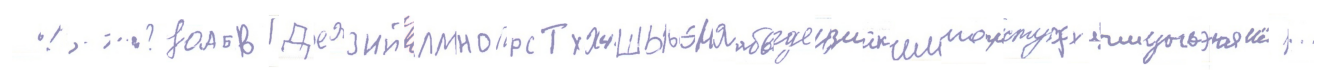

In [ ]:
t = ' !(,-.:?HoАБВГДЕЖЗИЙКЛМНОПРСТУХЧШЫЬЭЮЯабвгдежзийклмнопрстуфхцчшщыьэюяё-…'
img = stackmix.run_stackmix(t)
mask = np.min(img, axis=2) < 200
#print(mask.shape, img.shape)
mean_color = np.mean(img[mask], axis=0)
print(mean_color)
img[mask] = mean_color
plt.figure(num=None, figsize=(14, 14), dpi=120, facecolor='w', edgecolor='k');
plt.imshow(img)
plt.axis(False)

In [12]:
def generate(data, name, labels):
  #data = data.strip()
  i = 0
  print(len(data), name)
  while i < len(data):
    if not any(x not in ' !(,-.:?HoАБВГДЕЖЗИЙКЛМНОПРСТУХЧШЫЬЭЮЯабвгдежзийклмнопрстуфхцчшщыьэюяё-…' for x in data[i]):
      if i % 5 == 0:
        if i + 1 < len(data):
          if not any(x not in ' !(,-.:?HoАБВГДЕЖЗИЙКЛМНОПРСТУХЧШЫЬЭЮЯабвгдежзийклмнопрстуфхцчшщыьэюяё-…' for x in data[i+1]):
            t = data[i] + " " + data[i + 1]
            
            img = stackmix.run_stackmix(t)
            mask = np.min(img, axis=2) < 200
            mean_color = np.mean(img[mask], axis=0)
            img[mask] = mean_color
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            if not img is None:
              cv2.imwrite(f"/content/generated_words/{name}_{i}.png", img)
              labels["image"].append(f"{name}_{i}.png")
              labels["label"].append(t )
              labels["mean_color"].append(1)
      elif i % 2 == 0:
        t = data[i]
        labels["image"].append(f"{name}_{i}.png")
        labels["label"].append(t)
        labels["mean_color"].append(1)
        img = stackmix.run_stackmix(t)
        mask = np.min(img, axis=2) < 200
        mean_color = np.mean(img[mask], axis=0)
        img[mask] = mean_color
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        if not img is None:
          cv2.imwrite(f"/content/generated_words/{name}_{i}.png", img)
          labels["image"].append(f"{name}_{i}.png")
          labels["label"].append(t)
          labels["mean_color"].append(1)
      else:
        t = data[i]
        img = stackmix.run_stackmix(t)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        if not img is None:
          cv2.imwrite(f"/content/generated_words/{name}_{i}.png", img)
          labels["image"].append(f"{name}_{i}.png")
          labels["label"].append(t)
          labels["mean_color"].append(0)
    i += 1
    if i % 100  == 0:
      print(i)
    #plt.figure(num=None, figsize=(14, 14), dpi=120, facecolor='w', edgecolor='k');
    #plt.imshow(img)
    #plt.axis(False)
  return labels






In [17]:
import pandas as pd
aa = pd.read_csv("/content/generated_words_2.csv")
#print(aa.loc[aa["image"] == '0_57022.png', 'label'])
# aa.loc[aa['image'] == '0_1078.png', 'label']
# bb = aa.drop_duplicates(subset=["image", "label", "mean_color"])
# bb.to_csv("/content/generated_words_2.csv")
# aa

In [18]:
aa

,Unnamed: 0,Unnamed: 0.1,image,label,mean_color
0,0,0,0_6.png,СПЛОШНАЯ,1
1,2,2,0_7.png,СКУКА,0
2,3,3,0_8.png,Глава,1
3,5,5,0_10.png,После полуденного,1
4,6,6,0_11.png,полуденного,0
...,...,...,...,...,...
122320,171832,171832,0_131790.png,и усовершенствования,1
122321,171833,171833,0_131791.png,усовершенствования,0
122322,171834,171834,0_131792.png,врачей.,1
122323,171836,171836,0_131793.png,Взято,0


In [ ]:
texts = ["/content/drive/MyDrive/НТИ ИИ /data_team/Raynov_Emil-Boev_3_Sploshnaya-skuka-Rekviem-po-shalave_RuLit_Me.txt"]
labels = {"image": [], "label": [], "mean_color": []}
for i in range(len(texts)):
  with open(texts[i], encoding="utf-8") as f:
    a = f.read().strip().split()
    
    labels = generate(a, str(i), labels)
    df = pd.DataFrame(labels)
    print(labels)
    df.to_csv("/content/drive/MyDrive/НТИ ИИ /data_team/generated_words_2.csv")
    df.to_csv("/content/generated_words.csv")


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
import os
import zipfile
from tqdm.notebook import tqdm
 
# Declare the function to return all file paths of the particular directory
def retrieve_file_paths(dirName):
 
  # setup file paths variable
  filePaths = []
   
  # Read all directory, subdirectories and file lists
  for root, directories, files in os.walk(dirName):
    for filename in files:
        # Create the full filepath by using os module.
        filePath = os.path.join(root, filename)
        filePaths.append(filePath)
         
  # return all paths
  return filePaths
 
 
# Declare the main function
def main():
# Assign the name of the directory to zip
  dir_name = '/content/generated_words'
   
  # Call the function to retrieve all files and folders of the assigned directory
  filePaths = retrieve_file_paths(dir_name)
   
  # printing the list of all files to be zipped
  print('The following list of files will be zipped:')
  print(len(filePaths))

     
  # writing files to a zipfile
  zip_file = zipfile.ZipFile(dir_name+'.zip', 'w')
  with zip_file:
    # writing each file one by one
    for file in tqdm(filePaths):
      zip_file.write(file)
       
  print(dir_name+'.zip file is created successfully!')

main()

The following list of files will be zipped:
122325


  0%|          | 0/122325 [00:00<?, ?it/s]

/content/generated_words.zip file is created successfully!


In [14]:
print(len(os.listdir("/content/generated_words")))

122325


In [ ]:

text_rus = '''Однажды в студеную зимнюю пору я из лесу вышел был сильный мороз'''

In [ ]:
def get_bin_mask(image):
    img = image.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(img,(5,5),0)
    ret3, mask = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    kernel = np.ones((2,2),np.uint8)
    mask = ~mask.astype(np.bool)

    bg = np.ones(image.shape, dtype=np.uint8) * 255
    bg[mask] = image[mask].copy()

    return bg

def run_stackmix(sm, text, tokenizer=None):
        if tokenizer is None:
            tokenizer = random.choices(
                population=[
                    sm.tokenizers[3],
                    sm.tokenizers[4],
                    sm.tokenizers[5],
                    sm.tokenizers[6],
                    sm.tokenizers[7],
                    sm.tokenizers[8],
                ],
                weights=[0.05, 0.15, 0.20, 0.20, 0.20, 0.20],
                k=1
            )[0]

        image, left_x = None, None

        spans = sm.get_spans(text, tokenizer)
        if not sm.check_spans(spans):
            return

        for span in spans:
            word_token, (span_a, span_b), token = span
            if image is None:
                path = random.choice(sm.token2path.loc[word_token]['path'])
                image = cv2.imread(path)
                left_x = sm.path2leftx.loc[path]['left_x']
            else:
                path = random.choice(sm.token2path.loc[word_token]['path'])
                stack_image = cv2.imread(path)
      
                stack_left_x = sm.path2leftx.loc[path]['left_x']
                image = sm.stack_images(image, stack_image, sm.angle, stack_left_x)
                left_x = stack_left_x 

        return image

def resize_if_need(image, max_h, max_w):
    img = image.copy()
    img_h, img_w, img_c = img.shape
    coef = 1 if img_h <= max_h and img_w <= max_w else max(img_h / max_h, img_w / max_w)
    h = int(img_h / coef)
    w = int(img_w / coef)
    img = cv2.resize(img, (w, h))
    return img
    
def make_img_padding(image, max_h, max_w):
    img = image.copy()
    img_h, img_w, img_c = img.shape
    bg = np.ones((max_h, max_w, img_c), dtype=np.uint8)*255
    x1 = (max_w - img_w) // 2
    y1 = (max_h - img_h) // 2
    x2 = x1 + img_w
    y2 = y1 + img_h
    bg[y1:y2, x1:x2, :] = img.copy()
    return bg

def get_text_mask(image):
    img = image.copy()
    COLOR_MIN = np.array([0, 0, 0],np.uint8)
    COLOR_MAX = np.array([255, 255, 150],np.uint8)

    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    text_mask = cv2.inRange(img, COLOR_MIN, COLOR_MAX).astype(bool)

    return text_mask

def calc_mask_mean(images, index, window):
    img = np.zeros(images[0].shape, dtype=np.float32)
    img_count = 0
    for i in range(index - window, index):
        img += images[i]
        img_count += 1
        
    img = img / img_count
    img = np.clip(img, 0, 255)
    img = img.astype(np.uint8)
    return img

def smash_color(image, color_min, color_max):
    out_img = image.copy()

    out_img = cv2.cvtColor(out_img, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(out_img, color_min, color_max)
    out_img = cv2.cvtColor(out_img, cv2.COLOR_HSV2RGB)
    bool_mask = mask.astype(bool)

    white_bg = np.ones(out_img.shape, dtype=np.uint8) * 255

    white_bg[bool_mask] = out_img[bool_mask]

    w = 32 
    steps = out_img.shape[1] // w
    micro_step = out_img.shape[1] % w

    img_parts = [white_bg[:, i*w:i*w + w] for i in range(steps)]

    background = np.zeros(out_img.shape, dtype=np.uint8)
    
    for i in range(steps):
        background[:, i*w:i*w + w] = calc_mask_mean(img_parts, i, steps)

    background[:, -1 * micro_step:, :] = white_bg[:, -1 * micro_step:, :]
    
    out_img[bool_mask] = background[bool_mask]

    return out_img

def get_text_from_image(img):
    COLOR_MIN = np.array([0, 0, 0],np.uint8)
    COLOR_MAX = np.array([250,250,150],np.uint8)
    
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    text_mask = cv2.inRange(img, COLOR_MIN, COLOR_MAX).astype(bool)
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)

    bg = np.ones(img.shape, dtype=np.uint8) * 255
    bg[text_mask] = img[text_mask]
    return bg

def prepare_text(text):
    drop_chars = ['.', ',', ';', ':', '-', '«', '»',]
    text = text.translate({ord(x): '' for x in drop_chars})
    return text.lower()

def show_image(image):
    img = image.copy()
    plt.figure(figsize=(14, 14), dpi=300);
    plt.imshow(img);
    plt.axis(False);
    plt.show();

однажды в студеную зимнюю пору я из лесу вышел был сильный мороз


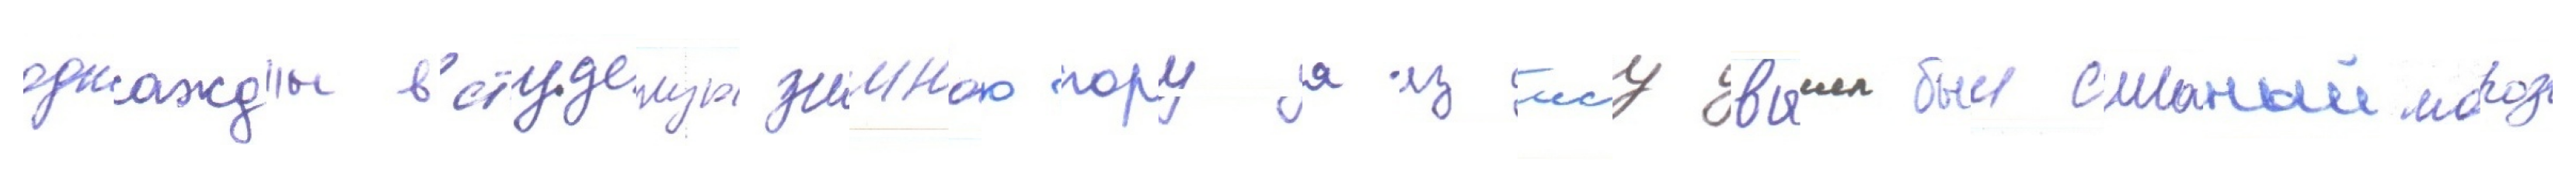

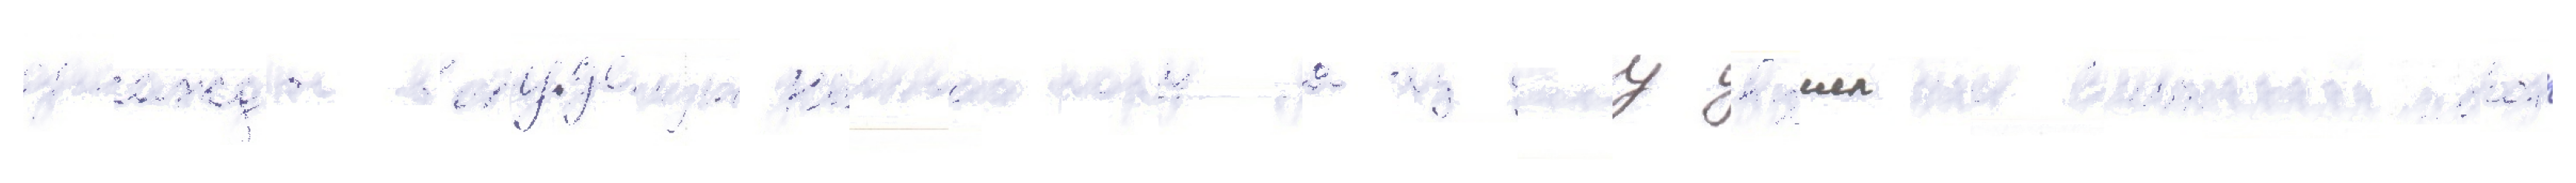

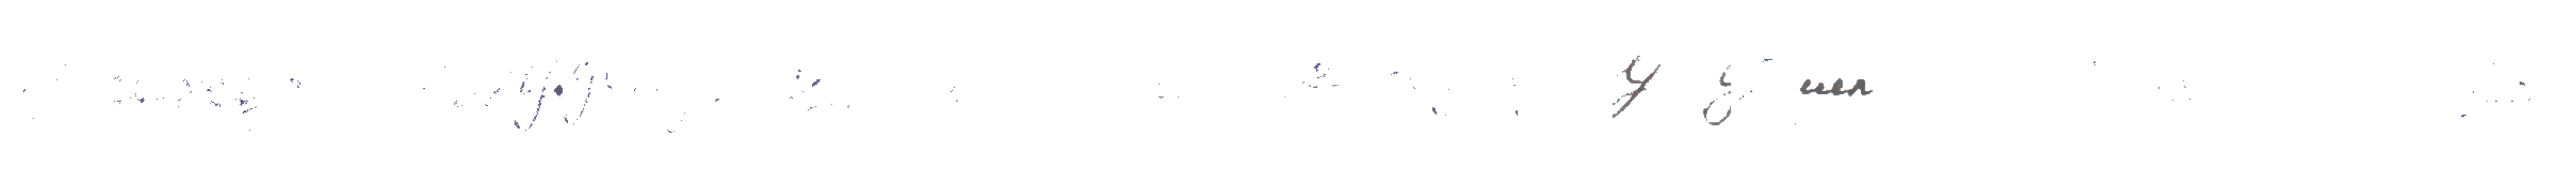

In [ ]:
p_text = prepare_text(text_rus)
print(p_text)

img = run_stackmix(stackmix, p_text, tokenizer=None)
show_image(img)

color_min = np.array([70, 2, 160],np.uint8)
color_max = np.array([140, 255, 255],np.uint8)

img = smash_color(img, color_min, color_max)
show_image(img)

img = get_text_from_image(img)
show_image(img)